In [17]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import pandas as pd
device="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from pathlib import Path
import glob

# find all images in subfolders
all_images = glob.glob("C:/Users/nihal/Downloads/archive/afhq/*/*/*.jpg")

image_path = []
labels = []

for img in all_images:
    image_path.append(img)
    labels.append(Path(img).parent.name)  # take the folder name as label

data_df = pd.DataFrame({"image_path": image_path, "labels": labels})
print(data_df['labels'].unique())
print(data_df.head())

['cat' 'dog' 'wild']
                                          image_path labels
0  C:/Users/nihal/Downloads/archive/afhq\train\ca...    cat
1  C:/Users/nihal/Downloads/archive/afhq\train\ca...    cat
2  C:/Users/nihal/Downloads/archive/afhq\train\ca...    cat
3  C:/Users/nihal/Downloads/archive/afhq\train\ca...    cat
4  C:/Users/nihal/Downloads/archive/afhq\train\ca...    cat


In [20]:
from sklearn.model_selection import train_test_split

# First split into train and temp (val+test)
train, temp = train_test_split(
    data_df, test_size=0.3, stratify=data_df['labels'], random_state=42
)

# Then split temp into val and test
val, test = train_test_split(
    temp, test_size=0.5, stratify=temp['labels'], random_state=42
)

print(f"Train shape: {train.shape}")
print(f"Val shape: {val.shape}")
print(f"Test shape: {test.shape}")

Train shape: (11291, 2)
Val shape: (2419, 2)
Test shape: (2420, 2)


In [21]:
# Encode labels (words → numbers)
label_encoder = LabelEncoder()
label_encoder.fit(data_df['labels'])

# Store class names for decoding later
class_names = label_encoder.classes_.tolist()
print("Class names:", class_names)

# Define image transforms
transform = transforms.Compose([
    transforms.Resize((128,128)),                      # resize all images to 128x128
    transforms.ToTensor(),                             # convert to PyTorch tensor (C,H,W)
    transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                         std=[0.5, 0.5, 0.5])          # normalize to [-1, 1]
])

Class names: ['cat', 'dog', 'wild']


In [22]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)  # ensure clean indexing
        self.transform = transform
        self.labels = label_encoder.transform(dataframe['labels']) 

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Apply transforms if given
        if self.transform:
            image = self.transform(image)

        # Return CPU tensors (device transfer happens in training loop)
        return image, torch.tensor(label, dtype=torch.long)


In [23]:
train_dataset=CustomImageDataset(dataframe=train,transform=transform)
val_dataset=CustomImageDataset(dataframe=val,transform=transform)
test_dataset=CustomImageDataset(dataframe=test,transform=transform)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 11291
Val samples: 2419
Test samples: 2420


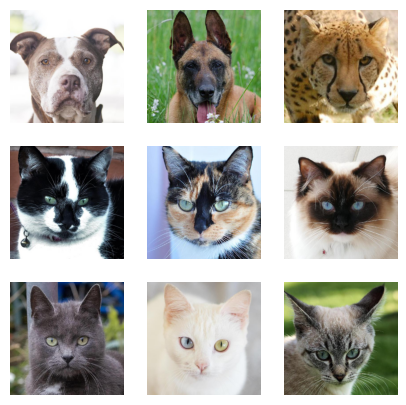

In [24]:
n_rows=3
n_cols=3
fig,ax=plt.subplots(n_rows,n_cols,figsize=(5,5))

for row in range(n_rows):
    for col in range(n_cols):
        image=Image.open(data_df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
        ax[row,col].imshow(image)
        ax[row,col].axis("off")
plt.show()
        

In [25]:
lr=0.001
batch_size=16
Epochs=10

In [26]:
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [27]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*16*16, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [28]:
model = CNNModel(num_classes=len(class_names)).to(device)

In [29]:
from torchsummary import summary
summary(model,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
         MaxPool2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
              ReLU-5           [-1, 64, 64, 64]               0
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
              ReLU-8          [-1, 128, 32, 32]               0
         MaxPool2d-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
             ReLU-12                  [-1, 128]               0
           Linear-13                    [-1, 3]             387
Total params: 4,288,067
Trainable param

In [30]:
criterion=nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

In [31]:
total_train_loss_plot = []    
total_val_loss_plot   = []
total_train_acc_plot  = []
total_val_acc_plot    = [] 

for epoch in range(Epochs):
    model.train()
    total_train_loss = 0
    total_train_correct = 0

    for inputs, labels in train_loader:
        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass + update
        loss.backward()
        optimizer.step()

        # Track metrics
        total_train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        total_train_correct += (preds == labels).sum().item()

    # Validation phase
    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            vloss = criterion(outputs, labels)

            total_val_loss += vloss.item()
            preds = torch.argmax(outputs, dim=1)
            total_val_correct += (preds == labels).sum().item()

    # Compute averages
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss   = total_val_loss / len(val_loader)
    train_acc      = total_train_correct / len(train_dataset) * 100  # percent
    val_acc        = total_val_correct / len(val_dataset) * 100      # percent

    # Save for plotting
    total_train_loss_plot.append(round(avg_train_loss, 4))
    total_val_loss_plot.append(round(avg_val_loss, 4))
    total_train_acc_plot.append(round(train_acc, 4))
    total_val_acc_plot.append(round(val_acc, 4))

    # Print progress
    print(f"Epoch {epoch+1}/{Epochs} | "
          f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
          f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

Epoch 1/10 | Train Loss: 0.3695, Val Loss: 0.1946, Train Acc: 84.86%, Val Acc: 92.85%
Epoch 2/10 | Train Loss: 0.1209, Val Loss: 0.1498, Train Acc: 95.76%, Val Acc: 94.50%
Epoch 3/10 | Train Loss: 0.0666, Val Loss: 0.1473, Train Acc: 97.44%, Val Acc: 95.29%
Epoch 4/10 | Train Loss: 0.0525, Val Loss: 0.1114, Train Acc: 98.27%, Val Acc: 96.03%
Epoch 5/10 | Train Loss: 0.0342, Val Loss: 0.2663, Train Acc: 98.68%, Val Acc: 93.68%
Epoch 6/10 | Train Loss: 0.0290, Val Loss: 0.1629, Train Acc: 98.92%, Val Acc: 95.82%
Epoch 7/10 | Train Loss: 0.0190, Val Loss: 0.1739, Train Acc: 99.41%, Val Acc: 95.99%
Epoch 8/10 | Train Loss: 0.0196, Val Loss: 0.2672, Train Acc: 99.42%, Val Acc: 95.00%
Epoch 9/10 | Train Loss: 0.0117, Val Loss: 0.2296, Train Acc: 99.59%, Val Acc: 95.91%
Epoch 10/10 | Train Loss: 0.0196, Val Loss: 0.2076, Train Acc: 99.42%, Val Acc: 95.49%


In [32]:
# Final evaluation on test set
model.eval()
total_test_loss = 0
total_test_correct = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # accumulate
        total_test_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        total_test_correct += (preds == labels).sum().item()

# Averages
avg_test_loss = total_test_loss / len(test_loader)
test_acc = total_test_correct / len(test_dataset) * 100

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.1764, Test Accuracy: 95.70%


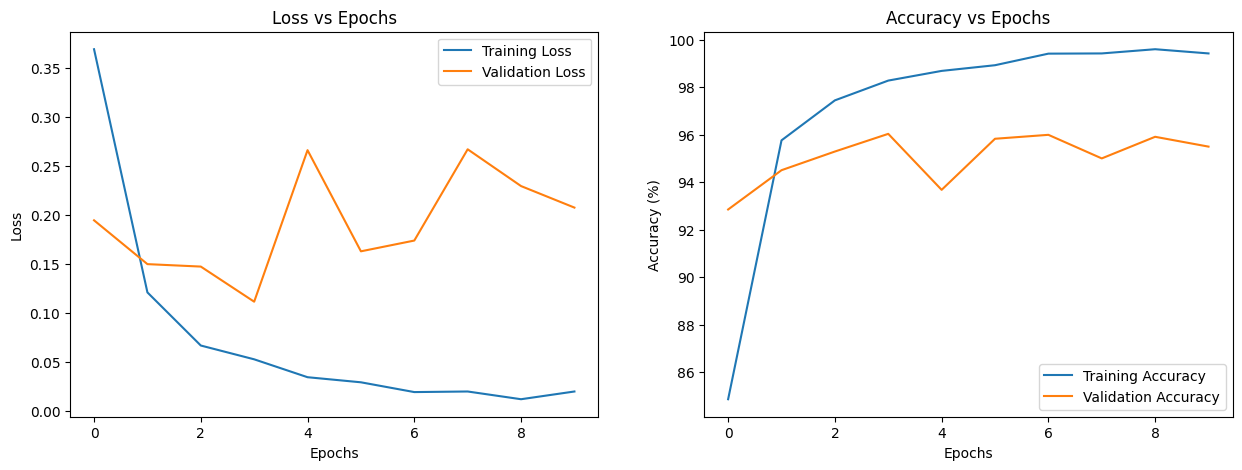

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

# --- Loss Plot ---
ax[0].plot(total_train_loss_plot, label="Training Loss")
ax[0].plot(total_val_loss_plot, label="Validation Loss")
ax[0].set_title("Loss vs Epochs")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()

# --- Accuracy Plot ---
ax[1].plot(total_train_acc_plot, label="Training Accuracy")
ax[1].plot(total_val_acc_plot, label="Validation Accuracy")
ax[1].set_title("Accuracy vs Epochs")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")   # <-- changed here
ax[1].legend()

plt.show()

FileUpload(value=(), accept='image/*', description='Upload')

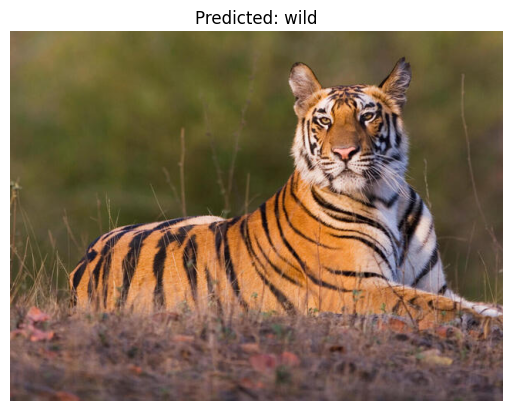

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch
import io

# Transform must exactly match training
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def on_upload_change(change):
    files = uploader.value
    if isinstance(files, dict):   # newer ipywidgets: dict
        files = files.values()
    for file_info in files:
        name = file_info['name']
        content = file_info['content']

        # Load image from memory
        img = Image.open(io.BytesIO(content)).convert("RGB")

        # Show uploaded image
        plt.imshow(img)
        plt.axis("off")

        # Preprocess
        img_t = transform(img).unsqueeze(0).to(device)

        # Predict
        model.eval()
        with torch.no_grad():
            output = model(img_t)
            pred_idx = torch.argmax(output, dim=1).item()

        # Show prediction
        plt.title(f"Predicted: {class_names[pred_idx]}")
        plt.show()

# Upload widget
uploader = widgets.FileUpload(accept='image/*', multiple=False)
uploader.observe(on_upload_change, names='value')
display(uploader)